## Import library

In [1]:
import numpy as np
import os
import gc
import pandas as pd
import seaborn as sns
import imagehash
from pathlib import Path
from glob import glob # parse the files name
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from subprocess import check_output

## Set data path

In [2]:
main_path = Path('../../../data/humpback-whale-identification-challenge')
train_path = main_path / 'train'
test_path = main_path / 'test'
train_images = glob(str(train_path / '*.jpg'))
test_image = glob(str(test_path / '*.jpg'))
df = pd.read_csv(str(main_path / 'train.csv'))

In [3]:
print('Number of train images: {}\nNumber of test images: {}'.format(
    len(train_images), len(test_image)))

Number of train images: 9850
Number of test images: 15610


# Data Clean
* Duplicate Images (要針對image的內容來看)


In [4]:
df['Image'] = df['Image'].map(lambda x: str(train_path / x))
ImageToLabelDict = dict(zip(df['Image'], df['Id']))

In [5]:
df[df.Id == 'w_6384242']

,Image,Id
4821,../../../data/humpback-whale-identification-ch...,w_6384242


In [6]:
def getImageMetaData(file_path):
    with Image.open(file_path) as img:
        img_hash = imagehash.phash(img)
        return img.size, img.mode, img_hash

m = df['Image'].apply(lambda x: getImageMetaData(x))

In [7]:
m.head()

0       ((699, 500), L, b362cc79b1a623b8)
1    ((1050, 700), RGB, b3cccc3331cc8733)
2    ((1050, 368), RGB, bc4ed0f2a7e168a8)
3     ((397, 170), RGB, 93742d9a28b35b87)
4       ((700, 398), L, d4a1dab1c49f6352)
Name: Image, dtype: object

In [8]:
df['Hash'] = [str(i[2]) for i in m]
df['Shape'] = [i[0] for i in m]
df['Mode'] = [str(i[1]) for i in m]
df['Length'] = df['Shape'].apply(lambda x: x[0]*x[1])
df['Ratio'] = df['Shape'].apply(lambda x: x[0]/x[1])
df['isNewWhale'] = df['Id'] == 'new_whale'

In [9]:
df.head()

,Image,Id,Hash,Shape,Mode,Length,Ratio,isNewWhale
0,../../../data/humpback-whale-identification-ch...,w_e15442c,b362cc79b1a623b8,"(699, 500)",L,349500,1.398000,False
1,../../../data/humpback-whale-identification-ch...,w_1287fbc,b3cccc3331cc8733,"(1050, 700)",RGB,735000,1.500000,False
2,../../../data/humpback-whale-identification-ch...,w_da2efe0,bc4ed0f2a7e168a8,"(1050, 368)",RGB,386400,2.853261,False
3,../../../data/humpback-whale-identification-ch...,w_19e5482,93742d9a28b35b87,"(397, 170)",RGB,67490,2.335294,False
4,../../../data/humpback-whale-identification-ch...,w_f22f3e3,d4a1dab1c49f6352,"(700, 398)",L,278600,1.758794,False


In [10]:
hash_image_count = df['Hash'].value_counts()

In [11]:
t = hash_image_count.loc[hash_image_count>1]
print("There are {} duplicate images.".format(np.sum(t)-len(t)))
t.head()

There are 778 duplicate images.


bb8ec43039cb663c    3
e4d1996a96a5e958    2
8b84aea3e478da72    2
bedcc43384cc1dc3    2
f6091d1b96a6a1f4    2
Name: Hash, dtype: int64

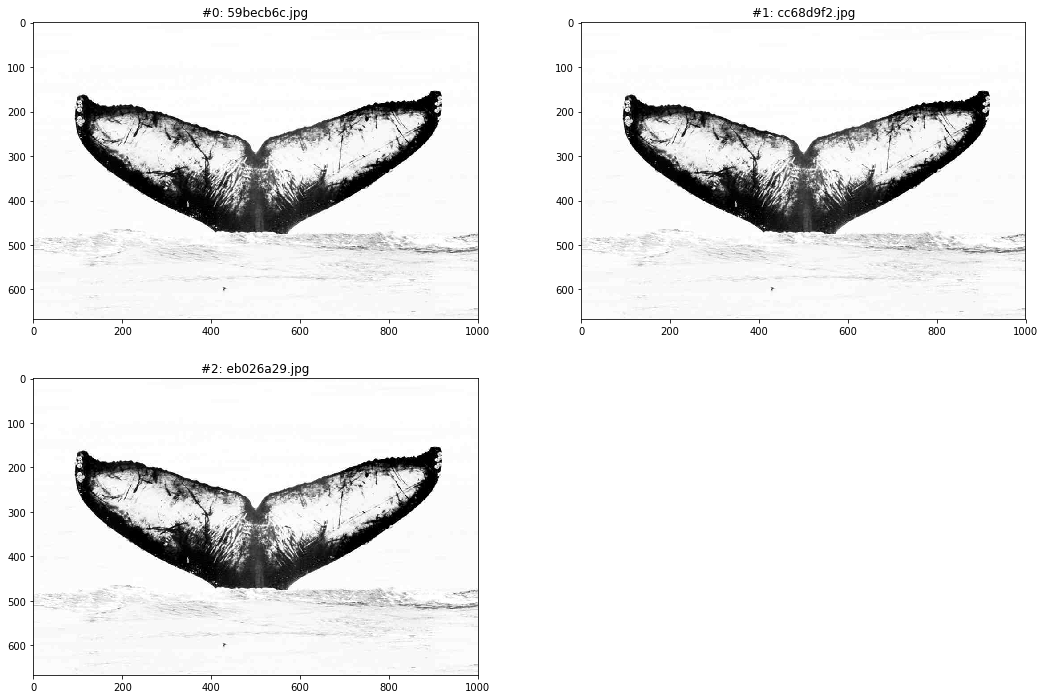

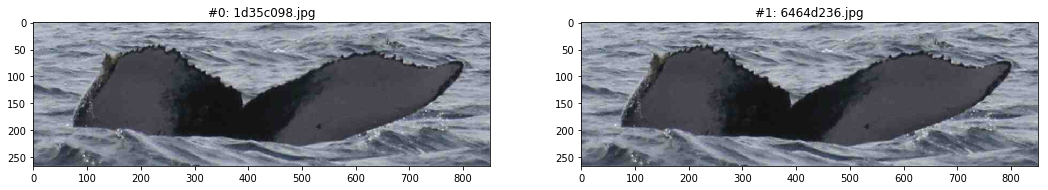

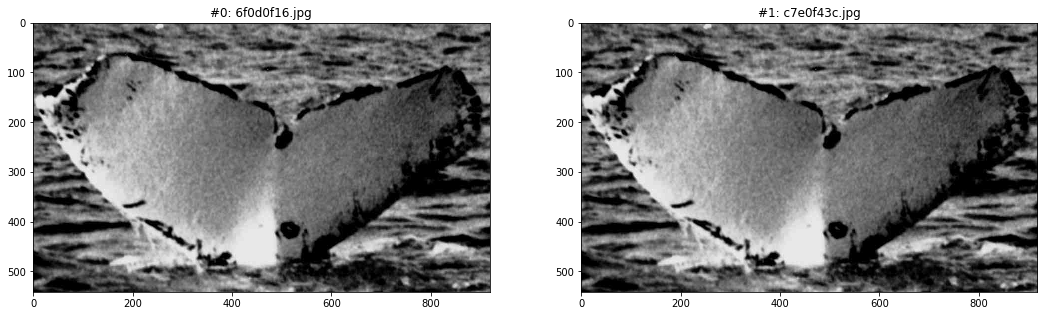

In [12]:
import collections
import re
def plot_duplicate_image(imgs):
    assert(isinstance(imgs, collections.Iterable))
    imgs_list = list(imgs)
    nrows = len(imgs_list)
    if (nrows % 2 != 0):
        nrows = nrows + 1
    plt.figure(figsize=(18, 6*nrows/2)) # 目的是讓圖的寬度相等呈現
    for i, img_file in enumerate(imgs_list):
        with Image.open(img_file) as img:
            ax = plt.subplot(nrows/2, 2, i+1)
            img_id = re.search('[\w\d]+(.)\w+$', img_file)
            ax.set_title('#{}: {}'.format(i, img_id.group(0)))
            ax.imshow(img)

plot_duplicate_image(df[df['Hash']==t.index[0]].Image)            
plot_duplicate_image(df[df['Hash']==t.index[3]].Image)   
plot_duplicate_image(df[df['Hash']==t.index[8]].Image)

In [42]:
# Method one: delete all duplicate images
hash_count_df = hash_image_count.to_frame().reset_index().rename(index=str, 
                                                                 columns={'index':'Hash', 
                                                                          'Hash':'count'})
df = df.merge(hash_count_df, on='Hash', how='left')

In [44]:
df[df['Hash'] == 'ee1292c52c7bc627']

,Image,Id,Hash,Shape,Mode,Length,Ratio,isNewWhale,count
5,../../../data/humpback-whale-identification-ch...,w_8b1ca89,ee1292c52c7bc627,"(1000, 652)",RGB,652000,1.533742,False,2
9411,../../../data/humpback-whale-identification-ch...,w_8b1ca89,ee1292c52c7bc627,"(1000, 652)",RGB,652000,1.533742,False,2


In [57]:
drop_index_list = (df[df['count'] > 1]).index.tolist()
df.drop(drop_index_list, axis=0, inplace=True)

In [59]:
df.to_csv(str(main_path / 'train_data_clean.csv'), index=False)

In [60]:
df.shape

(8295, 9)